In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


Cells: 3722


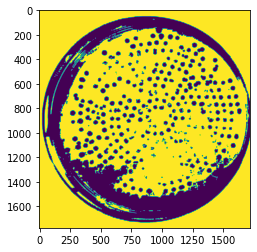

In [68]:
import cv2
import numpy as np
import math

image = cv2.imread("bactaria.jpg")
original = image.copy()
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

hsv_lower = np.array([0,40,50])
hsv_upper = np.array([179, 255, 255])
mask = cv2.inRange(hsv, hsv_lower, hsv_upper)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)

cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

minimum_area = 200
average_cell_area = 650
connected_cell_area = 1000
cells = 0
for c in cnts:
    area = cv2.contourArea(c)
    if area > minimum_area:
        cv2.drawContours(original, [c], -1, (36,255,12), 2)
        if area > connected_cell_area:
            cells += math.ceil(area / average_cell_area)
        else:
            cells += 1
print('Cells: {}'.format(cells))
# cv2.imshow('close', close)
# cv2.imshow('original', original)
# cv2.waitKey(0)
plt.imshow(close)

AttributeError: 'MainWindow' object has no attribute 'setupUi'

In [1]:
import cv2
import numpy as np
import math

image = cv2.imread("img.jpg")
original = image.copy()
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

hsv_lower = np.array([156,60,0])
hsv_upper = np.array([179,115,255])
mask = cv2.inRange(hsv, hsv_lower, hsv_upper)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)

cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

minimum_area = 200
average_cell_area = 650
connected_cell_area = 1000
cells = 0
for c in cnts:
    area = cv2.contourArea(c)
    if area > minimum_area:
        cv2.drawContours(original, [c], -1, (36,255,12), 2)
        if area > connected_cell_area:
            cells += math.ceil(area / average_cell_area)
        else:
            cells += 1
print('Cells: {}'.format(cells))
cv2.imshow('close', close)
cv2.imshow('Mask', mask)

cv2.imshow('original', original)
cv2.waitKey(0)
cv2.destroyAllWindows()

Cells: 75


In [17]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater

def ShowImage(title,img,ctype):
  if ctype=='bgr':
    b,g,r = cv2.split(img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
  elif ctype=='hsv':
    rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    plt.imshow(rgb)
  elif ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.title(title)
  plt.show()

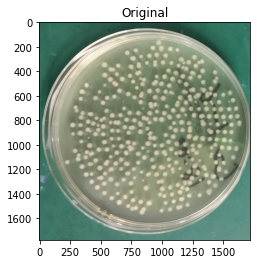

In [18]:
#Read in image
img         = cv2.imread('bactaria.jpg')
ShowImage('Original',img,'bgr')

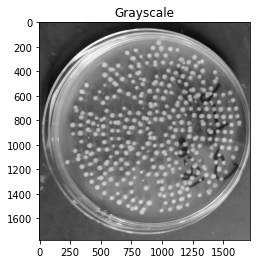

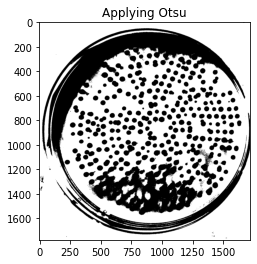

In [19]:
#Convert to a single, grayscale channel
gray        = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#Threshold the image to binary using Otsu's method
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
ShowImage('Grayscale',gray,'gray')
ShowImage('Applying Otsu',thresh,'gray')

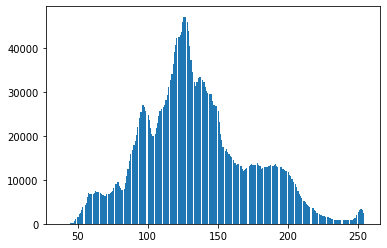

In [4]:
#Make a histogram of the intensities in the grayscale image
plt.hist(gray.ravel(),256)
plt.show()

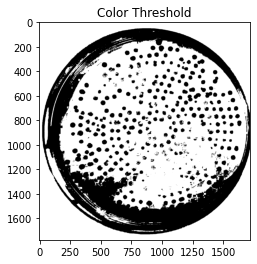

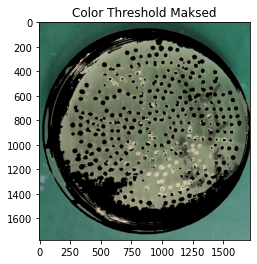

In [30]:
cell_hsvmin  = (0, 40, 50)  #Lower end of the HSV range defining the nuclei
cell_hsvmax  = (179, 255, 255) #Upper end of the HSV range defining the nuclei
# (hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
#Transform image to HSV color space
hsv          = cv2.cvtColor(img,cv2.COLOR_BGR2HSV) 
#Threshold based on HSV values
color_thresh = cv2.inRange(hsv, cell_hsvmin, cell_hsvmax) 
ShowImage('Color Threshold',color_thresh,'gray')

masked = cv2.bitwise_and(img,img, mask=color_thresh)
ShowImage('Color Threshold Maksed',masked,'bgr')

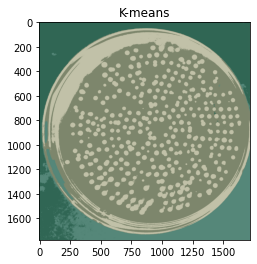

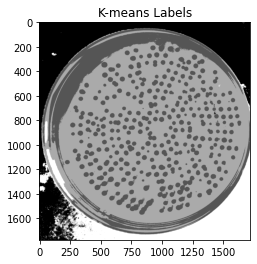

In [31]:
#Convert pixel space to an array of triplets. These are vectors in 3-space.
Z = hsv.reshape((-1,3)) 
#Convert to floating point
Z = np.float32(Z)
#Define the K-means criteria, these are not too important
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
#Define the number of clusters to find
K = 4
#Perform the k-means transformation. What we get back are:
#*Centers: The coordinates at the center of each 3-space cluster
#*Labels: Numeric labels for each cluster
#*Ret: A return code indicating whether the algorithm converged, &c.
ret,label,center = cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

#Produce an image using only the center colours of the clusters
center = np.uint8(center)
khsv   = center[label.flatten()]
khsv   = khsv.reshape((img.shape))
ShowImage('K-means',khsv,'hsv')

#Reshape labels for masking
label = label.reshape(img.shape[0:2])
ShowImage('K-means Labels',label,'gray')

In [32]:
#(Distance,Label) pairs
nucleus_colour = np.array([139, 106, 192])
cell_colour    = np.array([130, 41,  207])
nuclei_label  = (np.inf,-1)
cell_label    = (np.inf,-1)
for l,c in enumerate(center):
  print(l,c)
  dist_nuc = np.sum(np.square(c-nucleus_colour)) #Euclidean distance between colours
  if dist_nuc<nuclei_label[0]:
        nuclei_label=(dist_nuc,l)
  dist_cell = np.sum(np.square(c-cell_colour)) #Euclidean distance between colours
  if dist_cell<cell_label[0]:
        cell_label=(dist_cell,l)
nuclei_label = nuclei_label[1]
cell_label   = cell_label[1]
print("Nuclei label={0}, cell label={1}".format(nuclei_label,cell_label))

0 [ 80 133 102]
1 [ 30  32 193]
2 [ 40  48 134]
3 [ 82  94 135]
Nuclei label=3, cell label=1


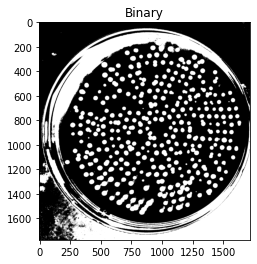

In [33]:
#Multiply by 1 to keep image in an integer format suitable for OpenCV
thresh = cv2.bitwise_or(1*(label==nuclei_label),1*(label==cell_label))
thresh = np.uint8(thresh)
ShowImage('Binary',thresh,'gray')

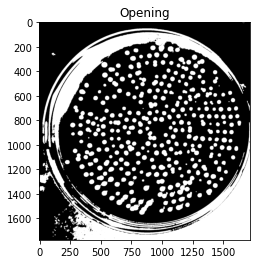

In [34]:
#Remove noise by eliminating single-pixel patches
kernel  = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel, iterations = 2)
ShowImage('Opening',opening,'gray')

In [36]:
edges= cv2.Canny(opening, 50,200)
contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

number_of_objects_in_image= len(contours)

print ("The number of objects in this image: ", str(number_of_objects_in_image))

The number of objects in this image:  0


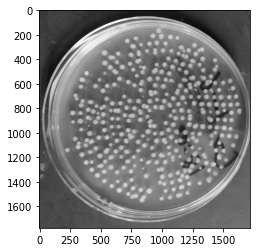

In [39]:
import cv2


image= cv2.imread('/home/ali/Desktop/python_chilla/Python_Chilla/projects/bacterial_count/bactaria.jpg')

# gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

# edges= cv2.Canny(gray, 50,200)

# contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# number_of_objects_in_image= len(contours)

# print ("The number of objects in this image: ", str(number_of_objects_in_image))

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

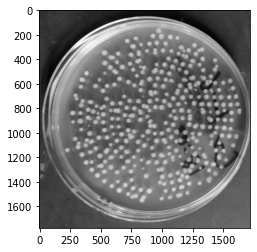

In [40]:
blur = cv2.GaussianBlur(gray, (11, 11), 0)
plt.imshow(blur, cmap='gray')

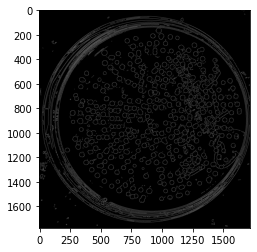

In [55]:

canny = cv2.Canny(blur, 20, 10, 10)
plt.imshow(canny, cmap='gray')

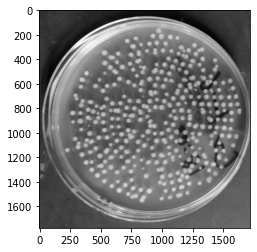

In [56]:

dilated = cv2.dilate(blur, (1, 1), iterations=0)
plt.imshow(dilated, cmap='gray')

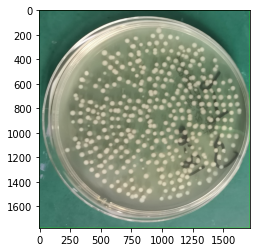

In [57]:
(cnt, hierarchy) = cv2.findContours(
    dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.drawContours(rgb, cnt, -1, (0, 255, 0), 2)
 
plt.imshow(rgb)

In [58]:
print("coins in the image : ", len(cnt))


coins in the image :  1


In [65]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
 
image = cv2.imread('/home/ali/Desktop/python_chilla/Python_Chilla/projects/bacterial_count/bactaria.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
blur = cv2.GaussianBlur(gray, (11, 11), 0)
canny = cv2.Canny(blur, 30, 150, 3)
dilated = cv2.dilate(canny, (1, 1), iterations=0)
 
(cnt, hierarchy) = cv2.findContours(
    dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.drawContours(rgb, cnt, -1, (0, 255, 0), 2)
 
 
print("coins in the image : ", len(cnt))

coins in the image :  52


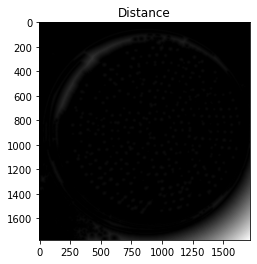

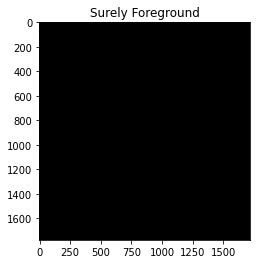

In [35]:
#Identify areas which are surely foreground
fraction_foreground = 5.05
dist         = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist,fraction_foreground*dist.max(),255,0)
ShowImage('Distance',dist,'gray')
ShowImage('Surely Foreground',sure_fg,'gray')

Peaks found: 2


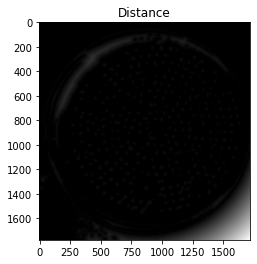

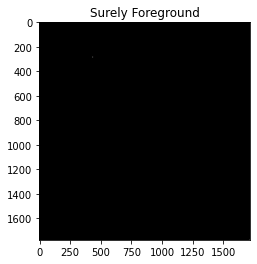

In [14]:
#Identify areas which are surely foreground
h_fraction = 0.1
dist     = cv2.distanceTransform(opening,cv2.DIST_L2,5)
maxima   = extrema.h_maxima(dist, h_fraction*dist.max())
print("Peaks found: {0}".format(np.sum(maxima)))
#Dilate the maxima so we can see them
maxima   = cv2.dilate(maxima, kernel, iterations=2)
ShowImage('Distance',dist,'gray')
ShowImage('Surely Foreground',maxima,'gray')

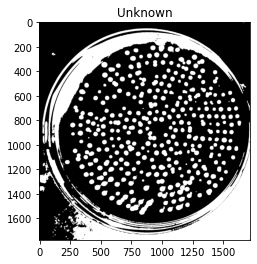

In [15]:
# Finding unknown region
unknown = cv2.subtract(opening,maxima)
ShowImage('Unknown',unknown,'gray')

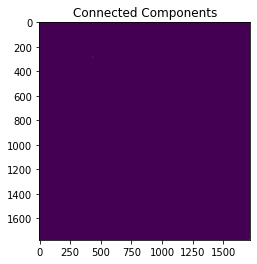

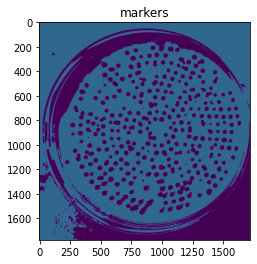

/home/ali/anaconda3/envs/chest-detect/lib/python3.6/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


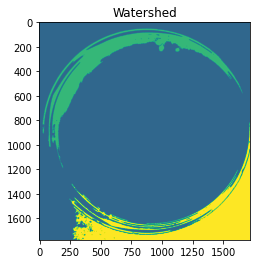

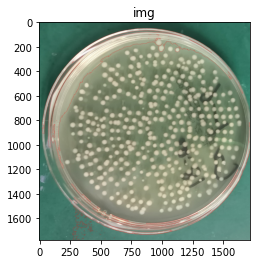

In [16]:
# Marker labelling
ret, markers = cv2.connectedComponents(maxima)
ShowImage('Connected Components',markers,'rgb')

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==np.max(unknown)] = 0

ShowImage('markers',markers,'rgb')

dist    = cv2.distanceTransform(opening,cv2.DIST_L2,5)
markers = skwater(-dist,markers,watershed_line=True)

ShowImage('Watershed',markers,'rgb')
imgout = img.copy()
imgout[markers == 0] = [0,0,255] #Label the watershed_line

ShowImage('img',imgout,'bgr')

In [25]:
import cv2
import numpy as np

def nothing(x):
    pass

# Load image
image = cv2.imread('/home/ali/Desktop/python_chilla/Python_Chilla/projects/bacterial_count/bactaria.jpg')

# Create a window
cv2.namedWindow('image')

# Create trackbars for color change
# Hue is from 0-179 for Opencv
cv2.createTrackbar('HMin', 'image', 0, 179, nothing)
cv2.createTrackbar('SMin', 'image', 0, 255, nothing)
cv2.createTrackbar('VMin', 'image', 0, 255, nothing)
cv2.createTrackbar('HMax', 'image', 0, 179, nothing)
cv2.createTrackbar('SMax', 'image', 0, 255, nothing)
cv2.createTrackbar('VMax', 'image', 0, 255, nothing)

# Set default value for Max HSV trackbars
cv2.setTrackbarPos('HMax', 'image', 179)
cv2.setTrackbarPos('SMax', 'image', 255)
cv2.setTrackbarPos('VMax', 'image', 255)

# Initialize HSV min/max values
hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

while(1):
    # Get current positions of all trackbars
    hMin = cv2.getTrackbarPos('HMin', 'image')
    sMin = cv2.getTrackbarPos('SMin', 'image')
    vMin = cv2.getTrackbarPos('VMin', 'image')
    hMax = cv2.getTrackbarPos('HMax', 'image')
    sMax = cv2.getTrackbarPos('SMax', 'image')
    vMax = cv2.getTrackbarPos('VMax', 'image')

    # Set minimum and maximum HSV values to display
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Convert to HSV format and color threshold
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    result = cv2.bitwise_and(image, image, mask=mask)

    # Print if there is a change in HSV value
    if((phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    # Display result image
    cv2.imshow('image', result)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
